In [14]:
import py4j
import pyspark
import platform
import re
import shutil
from pyspark.sql import HiveContext
import urllib
import numpy as np

from pyspark.context import SparkContext, SparkConf

In [15]:
print('                __                             ___            _aaaa')
print('               d8888aa,_                    a8888888a   __a88888888b')
print('              d8P   `Y88ba.                a8P''~~~~Y88a888P""~~~~Y88b')
print('             d8P      ~"Y88a____aaaaa_____a8P        888          Y88')
print('            d8P          ~Y88"8~~~~~~~88888P          88g          88')
print('           d8P                           88      ____ _88y__       88b')
print('           88                           a88    _a88~8888"8M88a_____888')
print('           88                           88P    88  a8"''     `888888888b_')
print('          a8P                           88     88 a88         88b     Y8,')
print('           8b                           88      8888P         388      88b')
print('          a88a                          Y8b       88L         8888.    88P')
print('         a8P                             Y8_     _888       _a8P 88   a88')
print('        _8P                               ~Y88a888~888g_   a888yg8''  a88')
print('        88                                   ~~~~    ~""8888        a88P')
print('       d8''                                                Y8,      888L')
print('       8E                                                  88a___a8"888')
print('      d8P                                                   ~Y888"   88L')
print('      88                                                      ~~      88')
print('      88                                                              88')
print('      88                                                              88b')
print('  ____88a_.      a8a                                                __881')
print('88""P~888        888b                                 __          8888888888')
print('      888        888P                                d88b             88')
print('     _888ba       ~            aaaa.                 8888            d8P')
print(' a888~"Y88                    888888                 "8P          8aa888_')
print('        Y8b                   Y888P"                                88""888a')
print('        _88g8                  ~~~                                 a88    ~~')
print('    __a8"888_                                                  a_ a88')
print('   88"''    "88g                                                 "888g_')
print('   ~         `88a_                                            _a88''"Y88gg,')
print('                "888aa_.                                   _a88"''      ~88')
print('                   ~~""8888aaa______                ____a888P')
print('                           ~~""""""888888888888888888""~~~')
print('                                      ~~~~~~~~~~~~')



                __                             ___            _aaaa
               d8888aa,_                    a8888888a   __a88888888b
              d8P   `Y88ba.                a8P~~~~Y88a888P""~~~~Y88b
             d8P      ~"Y88a____aaaaa_____a8P        888          Y88
            d8P          ~Y88"8~~~~~~~88888P          88g          88
           d8P                           88      ____ _88y__       88b
           88                           a88    _a88~8888"8M88a_____888
           88                           88P    88  a8"     `888888888b_
          a8P                           88     88 a88         88b     Y8,
           8b                           88      8888P         388      88b
          a88a                          Y8b       88L         8888.    88P
         a8P                             Y8_     _888       _a8P 88   a88
        _8P                               ~Y88a888~888g_   a888yg8  a88
        88                                   ~~~~    ~""8888        a8

In [16]:
from datetime import datetime
from datetime import timedelta

MIN_DATE = datetime.strptime('20110101', '%Y%m%d')
MAX_DATE = datetime.strptime('20110331', '%Y%m%d')

In [36]:
conf = (SparkConf()
           .setMaster("local")
           .setAppName("PySparkShell")
           .set("spark.executor.memory", "2g")
           .set("spark.core.connection.ack.wait.timeout", "600")
           .set("spark.akka.frameSize", "512")
           .set("spark.cassandra.output.batch.size.bytes", "131072")
      )
if SparkContext._active_spark_context is None:
    sc = SparkContext(conf = conf)

In [37]:
from pyspark.sql import SQLContext
sql = SQLContext(sc)

In [38]:
# Define current time
cur_time = datetime.now()
cur_time = datetime.strftime(cur_time, '%H:%M:%S')
cur_time

'08:56:58'

In [44]:
#############################################
# Enter a given date
#############################################


given_date = '03/02/2011'



given_date = given_date + '-' + cur_time
# convert it to datetime
today = datetime.strptime(given_date, '%d/%m/%Y-%H:%M:%S')
# check date
if (today < MIN_DATE) or (today > MAX_DATE):
    print 'Date is not valid - set it to '+datetime.strftime(MIN_DATE, '%d/%m/%Y')
    given_date = datetime.strftime(MIN_DATE, '%d/%m/%Y') + '-' + cur_time
    today = datetime.strptime(given_date, '%d/%m/%Y-%H:%M:%S')
print 'we are on: ', today

we are on:  2011-02-03 08:56:58


In [45]:
# set yesterday, set one month ago
yesterday = max(MIN_DATE, today + timedelta(days=-1))
one_month_ago = max(MIN_DATE, today + timedelta(days=-30))
print 'yesterday:    ', yesterday
print 'one month ago:', one_month_ago

yesterday:     2011-02-02 08:56:58
one month ago: 2011-01-04 08:56:58


In [46]:
# convert dates to db format
today_str = datetime.strftime(today, '%m%d')
day_hour = today.hour
yesterday_str = datetime.strftime(yesterday, '%m%d')
one_month_ago_str = datetime.strftime(one_month_ago, '%m%d')
#print today_str, day_hour, yesterday_str, one_month_ago_str

In [47]:
# All rows in a spark dataframe
all_rows = sql.read.format("org.apache.spark.sql.cassandra").load(keyspace="project", table="wiki_pagecounts1_2011")
# 24 hours dataframe
df_24h_1 = all_rows.filter(all_rows.month_day == yesterday_str)
df_24h_1 = df_24h_1.filter(df_24h_1.hour >= day_hour)
df_24h_2 = all_rows.filter(all_rows.month_day == today_str)
df_24h_2 = df_24h_2.filter(df_24h_2.hour < day_hour)
df_24h = df_24h_1.unionAll(df_24h_2)
#df_24h = df_24h.groupBy("month_day", 'prj', 'page').agg({"hits": "sum"}).sort("SUM(hits)", ascending=False)
df_24h = df_24h.groupBy('prj', 'page').agg({"hits": "sum"}).sort("SUM(hits)", ascending=False)
df_24h = df_24h.limit(20)
#df_24h.toPandas()

In [48]:
dataframe_24_h = df_24h.toPandas()
for x in dataframe_24_h.page: 
    pg = urllib.unquote(''+str(x)+'').decode('utf-8')
    dataframe_24_h.page.replace(x,pg, inplace = True)
dataframe_24_h

,prj,page,SUM(hits)
0,en.mw,en,14601443
1,en,Special:Random,6239691
2,en,Main_Page,5864594
3,en,Special:Search,4589527
4,ja.mw,ja,2235051
5,de,Wikipedia:Hauptseite,1560850
6,en,"Special:Export/A_K_Peters,_Ltd",1524995
7,en,"Special:Export/George_DeTitta,_Jr",1214069
8,ru,Заглавная_страница,1011114
9,it,Pagina_principale,914645


In [49]:
# with open('my_file.html', 'w') as fo:
#         dataframe_24_h.to_html(fo)
# for x in dataframe_24_h.page:
#     print x + str(isinstance(x, unicode)) +' '+  str(isinstance(x, str))

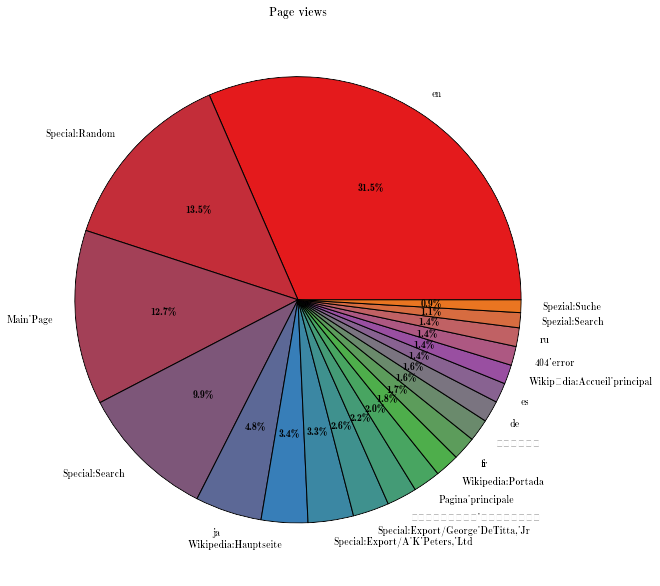

In [50]:
%matplotlib inline 

import matplotlib.pyplot as plt
from matplotlib import cm

cs=cm.Set1(np.arange(40)/40.)
plt.figure(figsize=(10,10))
x_list = dataframe_24_h['SUM(hits)']
label_list = dataframe_24_h['page']
plt.axis("equal") #The pie chart is oval by default. To make it a circle use pyplot.axis("equal")
#To show the percentage of each pie slice, pass an output format to the autopctparameter 
plt.pie(x_list,labels=label_list,autopct="%1.1f%%", colors=cs) 
plt.title("Page views")
plt.show()

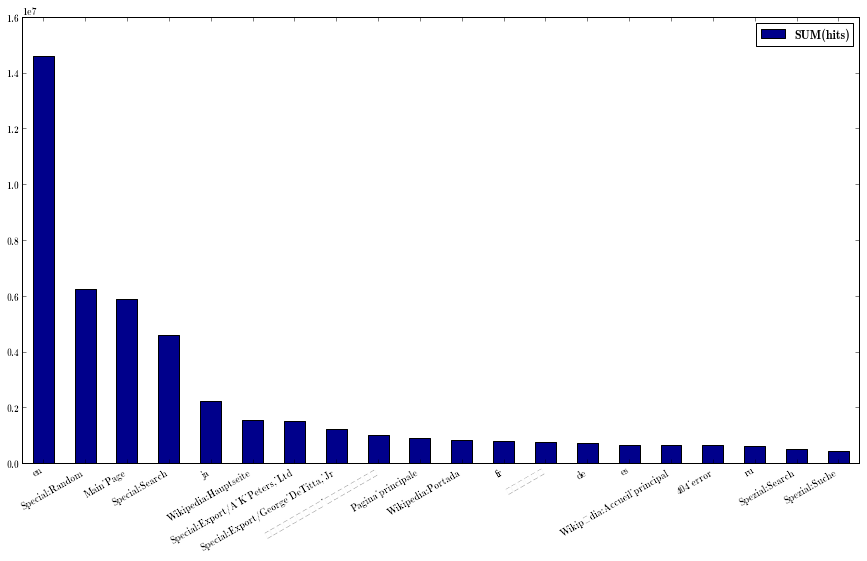

In [51]:
fig = plt.figure(figsize=(10,10))
ax = dataframe_24_h.plot(kind='bar',facecolor='darkblue', figsize=(15,8))
ax.set_xticklabels(dataframe_24_h['page'], rotation=30, fontsize=10, ha='right')
plt.savefig('static/styles/image_dataframe_24.png', dpi=fig.dpi)
plt.show()

In [53]:
# All rows in a spark dataframe
all_rows = sql.read.format("org.apache.spark.sql.cassandra").load(keyspace="project", table="wiki_pagecounts1_2011")
# 30 days dataframe
df_30d_1 = all_rows.filter(all_rows.month_day == one_month_ago_str)
df_30d_1 = df_30d_1.filter(df_30d_1.hour >= day_hour)
df_30d_2 = all_rows.filter(all_rows.month_day == today_str)
df_30d_2 = df_30d_2.filter(df_30d_2.hour < day_hour)
df_30d_3 = all_rows.filter(all_rows.month_day > one_month_ago_str)
df_30d_3 = all_rows.filter(df_30d_3.month_day < today_str)
df_30d = df_30d_1.unionAll(df_30d_2)
df_30d = df_30d.unionAll(df_30d_3)
df_30d = df_30d.groupBy('prj', 'page').agg({"hits": "sum"}).sort("SUM(hits)", ascending=False)
df_30d = df_30d.limit(20)
#df_30d.toPandas()

In [54]:
# import urllib 
dataframe_30_d = df_30d.toPandas()
# dataframe_30_d.page
dataframe_30_d

,prj,page,SUM(hits)
0,en.mw,en,526787342
1,en,Main_Page,186440721
2,en,Special:Random,182388815
3,en,Special:Search,149007205
4,ja.mw,ja,74108897
5,de,Wikipedia:Hauptseite,50134455
6,ru,%D0%97%D0%B0%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D0%...,34422144
7,de.mw,de,33928515
8,it,Pagina_principale,31765618
9,en,Special:Export/A_K_Peters%2c_Ltd,30903768


In [55]:
for x in dataframe_30_d.page: 
    try :
        pg = urllib.unquote(''+str(x)+'').decode('utf-8')
#         print pg
        dataframe_30_d.page.replace(x, pg, inplace = True)
    except :
        pass
#         print x

In [56]:
dataframe_30_d

,prj,page,SUM(hits)
0,en.mw,en,526787342
1,en,Main_Page,186440721
2,en,Special:Random,182388815
3,en,Special:Search,149007205
4,ja.mw,ja,74108897
5,de,Wikipedia:Hauptseite,50134455
6,ru,Заглавная_страница,34422144
7,de.mw,de,33928515
8,it,Pagina_principale,31765618
9,en,"Special:Export/A_K_Peters,_Ltd",30903768


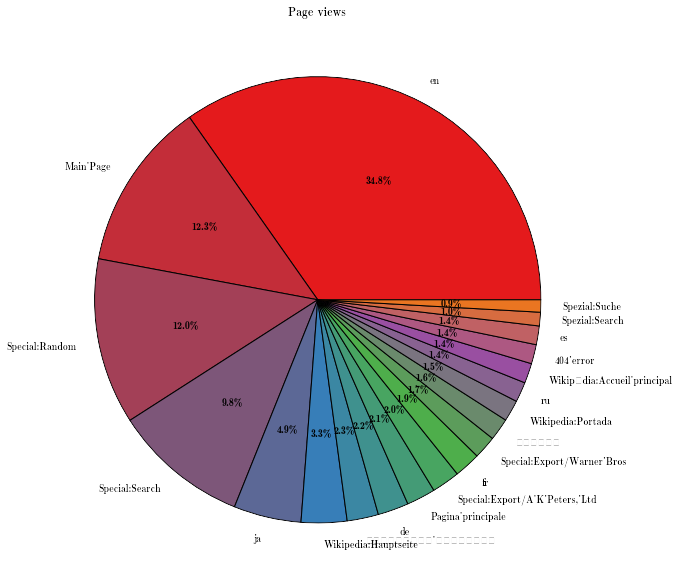

In [57]:
cs=cm.Set1(np.arange(40)/40.)
plt.figure(figsize=(10,10))
x_list = dataframe_30_d['SUM(hits)']
label_list = dataframe_30_d['page']
plt.axis("equal") #The pie chart is oval by default. To make it a circle use pyplot.axis("equal")
#To show the percentage of each pie slice, pass an output format to the autopctparameter 
plt.pie(x_list,labels=label_list,autopct="%1.1f%%", colors=cs) 
plt.title("Page views")
plt.show()

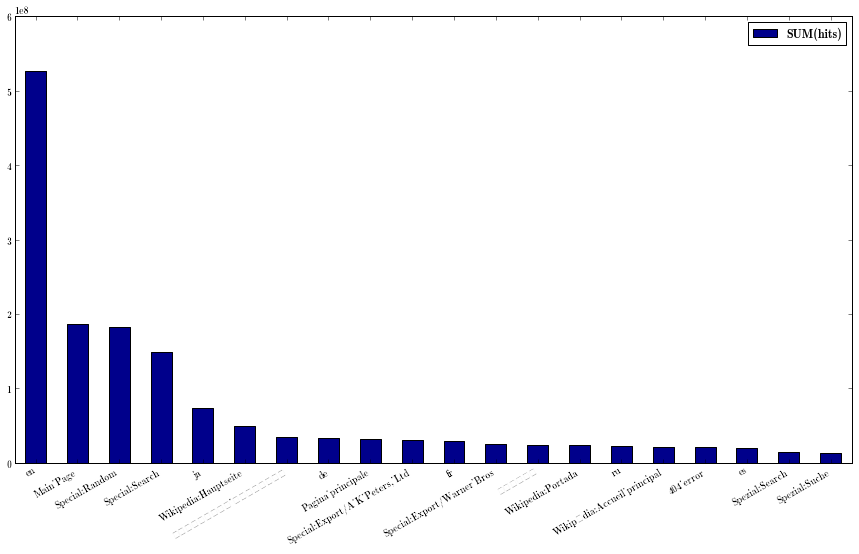

In [58]:
fig = plt.figure(figsize=(10,10))
ax = dataframe_30_d.plot(kind='bar',facecolor='darkblue', figsize=(15,8))
ax.set_xticklabels(dataframe_30_d['page'], rotation=30, fontsize=10, ha='right')
plt.savefig('static/styles/image_dataframe.png', dpi=fig.dpi)
plt.show()

In [286]:
# plt.savefig('static/styles/imagedataframe.png')
# plt.savefig('static/styles/imagedataframe.png', dpi=fig.dpi)


In [289]:
# import sys
# import os
# from flask import Flask,render_template,request, redirect 
# app = Flask(__name__)  # create a website in app

# @app.route('/')
# def hello_world():
#     author = "Me"
#     name = "You"
#     return render_template('myversion.html')
# app.run(host='ec2-54-172-174-138.compute-1.amazonaws.com', port=9998)